In [263]:
#
# Kalman Filter Example  
#
# "Introduction to Random Signals and Applied Kalman Filtering"
# Robert Grover Brown
# Patrick Y.C. Hwang
# Third edition. 
# 
#
import numpy as np
import matplotlib.pyplot as plt

04-Nov-22  CBL   Original

page 195
R is the autocorrelation function and for a Gauss-Markov process is defined by
$R_y(\tau) = \sigma^2 e^{- \beta \lvert \tau \rvert} $

<hr>
Other varible definitions

$x_k$ (n x 1) process state vector at time step k

$\phi_k$ (n x n) matrix relating $x_k to x_{k+1}$ in the absence of a forcing function (if $x_k$ is a sample of 
continuous process, $\phi_k$ is the usual state transisition matrix)

$w_k$ (n x 1) vector assumed to be a white sequence with known covariance structure

$z_k$ (m x 1) vector measurement at time $t_k$

$H_k$ (m x n) matrix giving the ideal noiseless connection between the measurement and the state vector at time $t_k$

$v_k$ ( m x 1) measurement error -  assumed to be a white sequence with known covariance structure and having
zero cross correlation with the $w_k$ sequence

$E[w_k,w_{i}^T] = (Q_k i=k) : (0, i \ne k) $

$E[v_k, v_{i}^T] = (R_k, i=k) : (0, i \ne k) $

$E[w_k, v{i}^T] = 0 \forall$ k and i 

Estimation error
$e_{k}^- = x_k - \hat{x}_{k}^-$

Error covariance matrix

$P_{k}^- = E[e_{k}^-,e_{k}^{-T}] = E[(x_k - \hat{x}_{k}^-)(x_k - \hat{x}_{k}^-)^T] $

$\hat{x}_{k} = \hat{x}_{k}^- + K_k(z_k - H_k \hat{x}_{k}^-)$
where
$\hat{x}_{k} = $ updated estimate Think of this as advancing the estimate and subracting it from the measurement. The resulting error is combined with the Kalman gain and the previous estimate to provide the next estimate.

$K_k$ = blending factor or Kalman Gain

$R_k$ the autocorrelation $\sigma^2 exp^{-\beta \lvert \tau \rvert} $

$Q_k$ is the expectaton value of the white noise from the system $E[w_k w_{k}^T]$

Finally we have:

$P_k = P_{k}^- - (I - K_k H_k) P_{k}^-$

$\hat{x}_{k+1}^- = \phi_k \hat{x_k}$

$P_{k+1}^- = \phi_k P_k \phi_{k}^T +Q_k $
<hr>
Process Steps
<ol>
    <li> use prior estimate $\hat{x}_{0}^- $ and its error covariance $\bf{P}_{0}^-$ </li>
    <li> Compute the Kalman Gain: $K_k = P_{k}^- H_{k}^T (H_k P_{k}^- H_{k}^T + R_k)^{-1} $ </li> 
    <li> Update the estimate with a measurement $z_k$: $\hat{x}_k = \hat{x}_{k}^- + K_k (z_k - H_k \hat{x}_{k}^-) $ </li>
    <li> Compute the error covariance for the updated estimate:  $\bf P_k = (I - K_k H_k)P_{k}^-$ </li>
    <li> Project ahead $\hat{x}_{k+1}^- = \phi_k \hat{x}_k $ </li>
    <li> Project ahead $P_{k+1}^- = \phi_k P_k \phi_{k}^T + Q_k $ </li>
</ol>
<hr>

In [264]:
class Kalman:
    def __init__(self):
        #
        # This can also be interpreted as the starting estimate. 
        self.X0 = np.zeros((9,1))   # Starting input vector, position (x,y,z), velocity and acceleration
        #
        # State vector at time step k
        self.X_k = np.zeros((9,1))
        #
        # State transisition matrix
        self.Phi_k = np.eye(9,9) 
        
        dt  = 0.5 # time step
        self.set_dt(dt)
        #
        # measurement vector ===================================================
        # This can be different size, eg, we only measure the position. 
        # 
        self.Z_k = np.zeros((3,1))
        #
        # measurement noise - white sequence? 
        #
        self.w_k = np.zeros((3,1))
        #
        # connection between measurement and state vector (mxn) in size
        # relationship is like (input 9 and output 3)
        #
        self.H_k = np.zeros((3,9))
        self.H_k[0,0] = 1
        self.H_k[1,1] = 1
        self.H_k[2,2] = 1
        #print("H_k: ", self.H_k)
        #
        #
        # measurement error
        self.v_k = [0.1, 0.1, 0.1]

        #
        # Initial covariance matrix - start with ones!
        #
        self.P0 = np.eye(9,9) 
        #
        # page 164 autocorrelation. 
        # page 195
        #
        # page 249
        # create the space
        self.R_k = np.eye(3,3)
        self.MakeAutocorrelation(0.05, 0.1, dt)
        #
        #
        #
        self.Q_k = np.zeros((9,9))
        #
        # Covariance Matrix
        #
        self.P_k = np.zeros((9,9))
        #
        # Kalman Gain
        #
        self.K = np.zeros((9,3))
        
    def set_dt(self, dt):
        #print ("dt: ", dt)
        self.dt = dt
        #
        # State advance matrix. 
        # CHECK!
        #
        self.Phi_k[0,3] = self.dt
        self.Phi_k[0,6] = self.dt*self.dt
        
        self.Phi_k[1,4] = self.dt
        self.Phi_k[1,7] = self.dt*self.dt

        self.Phi_k[2,5] = self.dt
        self.Phi_k[2,8] = self.dt*self.dt
        
        self.Phi_k[3,6] = self.dt
        self.Phi_k[4,7] = self.dt
        self.Phi_k[5,8] = self.dt
        
    def MakeAutocorrelation(self, sigma, beta, dt):
        """!MakeAutocorrelation
        @param sigma - spread of autocorrelation
        @param beta  - decay time in internal units. 
        @param dt    - step time in internal units. 
        
        Right now assuming the autocorrelation is the same for everything and no off-diagonal elements. 
        """
        self.R_k = self.R_k * sigma*sigma*np.exp(-1*beta*dt)
        #print ("R_k ", self.R_k)
        
    def Initialize(self):
        """@Initialize
        Set P_k and x_k to starting values P0 and X0
        """
        self.P_k = self.P0
        self.X_k = self.X0
    
    def setX(self, x, y, z=0):
        """@SetX 
        Set the starting position. 
        @param x - position
        @param y - position
        @param z - position
        """
        self.X0[0] = x
        self.X0[1] = y
        self.X0[2] = z
        
    def setV(self, x, y, z=0):
        """@SetV
        Set the starting Velocity 
        @param x - velocity component
        @param y - velocity component
        @param z - velocity component
        """
        self.X0[3] = x
        self.X0[4] = y
        self.X0[5] = z

    def setA(self, x, y, z=0):
        """@SetA
        Set the starting Acceleration 
        @param x - acceleration component
        @param y - acceleration component
        @param z - acceleration component
        """
        self.X0[6] = x
        self.X0[7] = y
        self.X0[8] = z
       
    def compute_Kalman_Gain(self):
        """@ComputeKalmanGain
        page 219
        Kalman Gain is 
            K = Pk H^T (HPH^T + R)^-1
        """
        A = self.P_k.dot(self.H_k.transpose())
        B = self.H_k.dot(A) 
        B = B + self.R_k
        #print("B:", B)
        C = np.linalg.inv(B)
        self.K = A.dot(C)
        #print(self.K)
    
    def updateMeasurement(self, x, y, z=0):
        """!addMeasurement
        Input a measurement into the system. and perform the calculation
        to update the estimate. 
        @param x - position
        @param y - position
        @param z - position (default is 0)
        """
        self.Z_k[0] = x
        self.Z_k[1] = y
        self.Z_k[2] = z
        A = self.Z_k - self.H_k.dot(self.X_k)
        #print(A)
        self.X_k = self.X_k + self.K.dot(A)
        #print(self.X_k) # This looks correct
        
    def computeCovariance(self):
        """@computeCovariance
        Compute the error covariance for the updated estimate.
        """
        A = np.eye(9,9) - self.K.dot(self.H_k)
        self.P_k = A.dot(self.P_k)
        #print (self.P_k)
    
    def project(self):
        """@project
        Project the measurement ahead.
        """
        self.X_k = self.Phi_k.dot(self.X_k)
        
    def loop(self, x, y):
        self.compute_Kalman_Gain()
        self.updateMeasurement(x,y)
        self.computeCovariance()
        self.project()
        
    def dump(self):
        print(self.X_k)
        

In [265]:
kal = Kalman()
#kal.Test()
kal.setV(0,2,0)
kal.Initialize()
#print(kal.X_k)
#kal.compute_Kalman_Gain()
#kal.updateMeasurement(0, 1.99, 0)
#kal.computeCovariance()
#kal.project()
kal.loop(0, 1.99)
kal.dump()

[[0.        ]
 [2.98527886]
 [0.        ]
 [0.        ]
 [2.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


Create a simulation for input

In [266]:
class SimulateMotion:
    def __init__(self):
        # X, velocity and acceleration.
        #
        # assemble these into a full vector. 
        self.X_k = np.zeros((9,1))
        
        #
        # State advance matrix. 
        #
        self.phi = np.eye(9,9)
        
        # timestep 
        self.set_dt(0.5)
        
        # Gaussian noise parameters, assume centered on zero. 
        self.x_sigma = 0.5
        self.v_sigma = 0.01
        self.a_sigma = 0.0001

    def set_dt(self, dt):
        print ("dt: ", dt)
        self.dt = dt
        #
        # State advance matrix. 
        # CHECK!
        #
        self.phi[0,3] = self.dt
        self.phi[0,6] = self.dt*self.dt
        
        self.phi[1,4] = self.dt
        self.phi[1,7] = self.dt*self.dt

        self.phi[2,5] = self.dt
        self.phi[2,8] = self.dt*self.dt
        
        self.phi[3,6] = self.dt
        self.phi[4,7] = self.dt
        self.phi[5,8] = self.dt


#        self.phi = [
#            [1, 0, 0, self.dt,      0,          0, self.dt*self.dt,               0,               0],
#            [0, 1, 0,      0, self.dt,          0,               0, self.dt*self.dt,               0],
#            [0, 0, 1,      0,      0,     self.dt,               0,               0, self.dt*self.dt],
#            [0, 0, 0,      1,      0,           0,         self.dt,               0,               0],
#            [0, 0, 0,      0,      1,           0,               0,         self.dt,               0],
##            [0, 0, 0,      0,      0,           1,               0,               0,         self.dt],
#            [0, 0, 0 ,     0,      0,           0,               1,               0,               0],
#            [0, 0, 0,      0,      0,           0,               0,               1,               0],
#            [0, 0, 0,      0,      0,           0,               0,               0,               1]
#       ]
        
    def setX(self, x):
        # @x input 3 vector for initial position. 
        # assemble these into a full vector. 
        self.X_k[0] = x[0]
        self.X_k[1] = x[1]
        self.X_k[2] = x[2]

        
    def setV(self, v):
        #@v input 3 vector for velocity
        # assemble these into a full vector. 
        self.X_k[3] = v[0]
        self.X_k[4] = v[1]
        self.X_k[5] = v[2]

        
    def setA(self, a):
        #@a input 3 vector for acceleration
        # assemble these into a full vector. 
        self.X_k[6] = a[0]
        self.X_k[7] = a[1]
        self.X_k[8] = a[2]

    def Noise(self):
        for i in range(3):
            self.X_k[i] = self.X_k[i] + np.random.normal(0, self.x_sigma, 1)
            self.X_k[i+3] = self.X_k[i+3] + np.random.normal(0, self.v_sigma, 1)
            self.X_k[i+6] = self.X_k[i+6] + np.random.normal(0, self.a_sigma, 1)
            
    def Advance(self):
        # get a new x, v, a vectors 
        self.X_k = self.phi.dot(self.X_k)
        # Add in noise
        
    def Test(self):
        #print(self.X_k)
        # Loop for multiple advances and plot. 
        npoints = 50
        x = np.zeros(npoints)
        y = np.zeros(npoints)
        for i in range(npoints):
            self.Advance()
            self.Noise()
            x[i] = self.X_k[0]
            y[i] = self.X_k[1]
        plt.plot(x,y)
        plt.show()

dt:  0.5


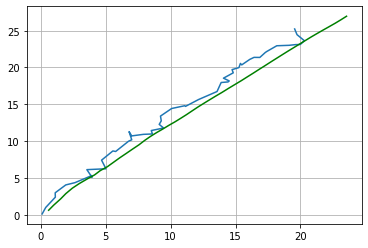

COV  [[4.75592092e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.75592092e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.75592092e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00]
 

In [274]:
kal = Kalman()
sim = SimulateMotion()
sim.setV([1, 1, 0])
kal.setV(1,1,0)
kal.Initialize()
#
#
npoints = 50
x = np.zeros(npoints)
y = np.zeros(npoints)
xk = np.zeros(npoints)
yk = np.zeros(npoints)
for i in range(npoints):
    sim.Advance()
    sim.Noise()
    x[i] = sim.X_k[0]
    y[i] = sim.X_k[1]
    kal.loop(x[i],y[i])
    xk[i] = kal.X_k[0]
    yk[i] = kal.X_k[1]
plt.grid()   
plt.plot(x,y)
plt.plot(xk,yk,'g-')
plt.show()
print("COV ", kal.P_k)